In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 1012)
(772408, 8)
validation
(101248, 1012)
(101248, 8)
test
(98888, 1012)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1012)]            0         


 dense (Dense)               (None, 1024)              1037312   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1727368 (6.59 MB)


Trainable params: 1727368 (6.59 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:40 - loss: 2.2487 - STD: 0.0542 - MAE: 0.2225

 4/78 [>.............................] - ETA: 1s - loss: 1.6979 - STD: 0.1058 - MAE: 0.1860  

 7/78 [=>............................] - ETA: 1s - loss: 1.5671 - STD: 0.1637 - MAE: 0.1608

10/78 [==>...........................] - ETA: 1s - loss: 1.5108 - STD: 0.1867 - MAE: 0.1508

13/78 [====>.........................] - ETA: 1s - loss: 1.4695 - STD: 0.1898 - MAE: 0.1488

16/78 [=====>........................] - ETA: 1s - loss: 1.4465 - STD: 0.1861 - MAE: 0.1498

19/78 [======>.......................] - ETA: 1s - loss: 1.4290 - STD: 0.1840 - MAE: 0.1503

22/78 [=======>......................] - ETA: 1s - loss: 1.4145 - STD: 0.1852 - MAE: 0.1496

25/78 [========>.....................] - ETA: 1s - loss: 1.4044 - STD: 0.1880 - MAE: 0.1483

28/78 [=========>....................] - ETA: 0s - loss: 1.3952 - STD: 0.1903 - MAE: 0.1472

31/78 [==========>...................] - ETA: 0s - loss: 1.3886 - STD: 0.1911 - MAE: 0.1468

34/78 [============>.................] - ETA: 0s - loss: 1.3820 - STD: 0.1907 - MAE: 0.1469

37/78 [=============>................] - ETA: 0s - loss: 1.3771 - STD: 0.1899 - MAE: 0.1471

40/78 [==============>...............] - ETA: 0s - loss: 1.3713 - STD: 0.1896 - MAE: 0.1470

43/78 [===============>..............] - ETA: 0s - loss: 1.3674 - STD: 0.1901 - MAE: 0.1468

46/78 [================>.............] - ETA: 0s - loss: 1.3651 - STD: 0.1907 - MAE: 0.1465

49/78 [=================>............] - ETA: 0s - loss: 1.3622 - STD: 0.1910 - MAE: 0.1464

52/78 [===================>..........] - ETA: 0s - loss: 1.3591 - STD: 0.1909 - MAE: 0.1464

55/78 [====================>.........] - ETA: 0s - loss: 1.3569 - STD: 0.1906 - MAE: 0.1464

58/78 [=====================>........] - ETA: 0s - loss: 1.3555 - STD: 0.1905 - MAE: 0.1464

61/78 [======================>.......] - ETA: 0s - loss: 1.3536 - STD: 0.1906 - MAE: 0.1464

64/78 [=======================>......] - ETA: 0s - loss: 1.3518 - STD: 0.1908 - MAE: 0.1463

67/78 [========================>.....] - ETA: 0s - loss: 1.3505 - STD: 0.1909 - MAE: 0.1462

71/78 [==========================>...] - ETA: 0s - loss: 1.3491 - STD: 0.1908 - MAE: 0.1463

74/78 [===========================>..] - ETA: 0s - loss: 1.3474 - STD: 0.1907 - MAE: 0.1463

77/78 [============================>.] - ETA: 0s - loss: 1.3465 - STD: 0.1907 - MAE: 0.1462

78/78 [==============================] - 4s 37ms/step - loss: 1.3464 - STD: 0.1907 - MAE: 0.1462 - val_loss: 1.2736 - val_STD: 0.1937 - val_MAE: 0.1441


Epoch 2/10000


 1/78 [..............................] - ETA: 4s - loss: 1.3183 - STD: 0.1938 - MAE: 0.1449

 4/78 [>.............................] - ETA: 1s - loss: 1.3167 - STD: 0.1930 - MAE: 0.1450

 7/78 [=>............................] - ETA: 1s - loss: 1.3147 - STD: 0.1916 - MAE: 0.1454

11/78 [===>..........................] - ETA: 1s - loss: 1.3171 - STD: 0.1909 - MAE: 0.1458

14/78 [====>.........................] - ETA: 1s - loss: 1.3172 - STD: 0.1911 - MAE: 0.1457

17/78 [=====>........................] - ETA: 1s - loss: 1.3170 - STD: 0.1914 - MAE: 0.1455

20/78 [======>.......................] - ETA: 1s - loss: 1.3170 - STD: 0.1915 - MAE: 0.1455

23/78 [=======>......................] - ETA: 0s - loss: 1.3160 - STD: 0.1915 - MAE: 0.1454

27/78 [=========>....................] - ETA: 0s - loss: 1.3161 - STD: 0.1915 - MAE: 0.1454

31/78 [==========>...................] - ETA: 0s - loss: 1.3162 - STD: 0.1914 - MAE: 0.1454

34/78 [============>.................] - ETA: 0s - loss: 1.3156 - STD: 0.1914 - MAE: 0.1454

37/78 [=============>................] - ETA: 0s - loss: 1.3151 - STD: 0.1913 - MAE: 0.1454

40/78 [==============>...............] - ETA: 0s - loss: 1.3157 - STD: 0.1913 - MAE: 0.1455

43/78 [===============>..............] - ETA: 0s - loss: 1.3155 - STD: 0.1913 - MAE: 0.1455

46/78 [================>.............] - ETA: 0s - loss: 1.3151 - STD: 0.1913 - MAE: 0.1454

49/78 [=================>............] - ETA: 0s - loss: 1.3144 - STD: 0.1913 - MAE: 0.1454

52/78 [===================>..........] - ETA: 0s - loss: 1.3136 - STD: 0.1913 - MAE: 0.1453

55/78 [====================>.........] - ETA: 0s - loss: 1.3125 - STD: 0.1913 - MAE: 0.1453

58/78 [=====================>........] - ETA: 0s - loss: 1.3113 - STD: 0.1914 - MAE: 0.1452

61/78 [======================>.......] - ETA: 0s - loss: 1.3096 - STD: 0.1914 - MAE: 0.1451

64/78 [=======================>......] - ETA: 0s - loss: 1.3084 - STD: 0.1915 - MAE: 0.1450

67/78 [========================>.....] - ETA: 0s - loss: 1.3066 - STD: 0.1915 - MAE: 0.1449

70/78 [=========================>....] - ETA: 0s - loss: 1.3045 - STD: 0.1917 - MAE: 0.1447

73/78 [===========================>..] - ETA: 0s - loss: 1.3025 - STD: 0.1919 - MAE: 0.1445

76/78 [============================>.] - ETA: 0s - loss: 1.3007 - STD: 0.1920 - MAE: 0.1444

78/78 [==============================] - 2s 21ms/step - loss: 1.2991 - STD: 0.1922 - MAE: 0.1443 - val_loss: 1.1950 - val_STD: 0.1887 - val_MAE: 0.1413


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.2452 - STD: 0.1969 - MAE: 0.1400

 4/78 [>.............................] - ETA: 1s - loss: 1.2431 - STD: 0.1971 - MAE: 0.1399

 7/78 [=>............................] - ETA: 1s - loss: 1.2445 - STD: 0.1974 - MAE: 0.1399

10/78 [==>...........................] - ETA: 1s - loss: 1.2446 - STD: 0.1975 - MAE: 0.1401

13/78 [====>.........................] - ETA: 1s - loss: 1.2404 - STD: 0.1976 - MAE: 0.1399

16/78 [=====>........................] - ETA: 1s - loss: 1.2351 - STD: 0.1976 - MAE: 0.1397

19/78 [======>.......................] - ETA: 1s - loss: 1.2316 - STD: 0.1982 - MAE: 0.1393

22/78 [=======>......................] - ETA: 1s - loss: 1.2283 - STD: 0.1989 - MAE: 0.1389

25/78 [========>.....................] - ETA: 1s - loss: 1.2272 - STD: 0.1988 - MAE: 0.1390

29/78 [==========>...................] - ETA: 1s - loss: 1.2249 - STD: 0.1983 - MAE: 0.1392

32/78 [===========>..................] - ETA: 0s - loss: 1.2220 - STD: 0.1984 - MAE: 0.1390

35/78 [============>.................] - ETA: 0s - loss: 1.2191 - STD: 0.1994 - MAE: 0.1385

38/78 [=============>................] - ETA: 0s - loss: 1.2161 - STD: 0.1994 - MAE: 0.1384

41/78 [==============>...............] - ETA: 0s - loss: 1.2136 - STD: 0.1994 - MAE: 0.1383

44/78 [===============>..............] - ETA: 0s - loss: 1.2117 - STD: 0.1997 - MAE: 0.1381

47/78 [=================>............] - ETA: 0s - loss: 1.2094 - STD: 0.1997 - MAE: 0.1381

50/78 [==================>...........] - ETA: 0s - loss: 1.2079 - STD: 0.1997 - MAE: 0.1380

53/78 [===================>..........] - ETA: 0s - loss: 1.2053 - STD: 0.2000 - MAE: 0.1379

56/78 [====================>.........] - ETA: 0s - loss: 1.2028 - STD: 0.2002 - MAE: 0.1377

59/78 [=====================>........] - ETA: 0s - loss: 1.2009 - STD: 0.2002 - MAE: 0.1377

62/78 [======================>.......] - ETA: 0s - loss: 1.1989 - STD: 0.2004 - MAE: 0.1375

65/78 [========================>.....] - ETA: 0s - loss: 1.1968 - STD: 0.2006 - MAE: 0.1374

68/78 [=========================>....] - ETA: 0s - loss: 1.1948 - STD: 0.2006 - MAE: 0.1373

71/78 [==========================>...] - ETA: 0s - loss: 1.1921 - STD: 0.2008 - MAE: 0.1372

74/78 [===========================>..] - ETA: 0s - loss: 1.1900 - STD: 0.2009 - MAE: 0.1371

77/78 [============================>.] - ETA: 0s - loss: 1.1877 - STD: 0.2010 - MAE: 0.1370

78/78 [==============================] - 2s 24ms/step - loss: 1.1868 - STD: 0.2010 - MAE: 0.1369 - val_loss: 1.0815 - val_STD: 0.2033 - val_MAE: 0.1328


Epoch 4/10000


 1/78 [..............................] - ETA: 4s - loss: 1.1181 - STD: 0.2112 - MAE: 0.1307

 4/78 [>.............................] - ETA: 1s - loss: 1.1206 - STD: 0.2045 - MAE: 0.1336

 7/78 [=>............................] - ETA: 1s - loss: 1.1177 - STD: 0.2041 - MAE: 0.1335

10/78 [==>...........................] - ETA: 1s - loss: 1.1146 - STD: 0.2040 - MAE: 0.1334

13/78 [====>.........................] - ETA: 1s - loss: 1.1114 - STD: 0.2045 - MAE: 0.1330

17/78 [=====>........................] - ETA: 1s - loss: 1.1079 - STD: 0.2047 - MAE: 0.1328

20/78 [======>.......................] - ETA: 1s - loss: 1.1050 - STD: 0.2055 - MAE: 0.1323

23/78 [=======>......................] - ETA: 1s - loss: 1.1022 - STD: 0.2054 - MAE: 0.1322

26/78 [=========>....................] - ETA: 1s - loss: 1.0995 - STD: 0.2057 - MAE: 0.1320

29/78 [==========>...................] - ETA: 1s - loss: 1.0957 - STD: 0.2062 - MAE: 0.1316

32/78 [===========>..................] - ETA: 0s - loss: 1.0914 - STD: 0.2066 - MAE: 0.1312

35/78 [============>.................] - ETA: 0s - loss: 1.0879 - STD: 0.2069 - MAE: 0.1309

38/78 [=============>................] - ETA: 0s - loss: 1.0856 - STD: 0.2072 - MAE: 0.1307

41/78 [==============>...............] - ETA: 0s - loss: 1.0813 - STD: 0.2079 - MAE: 0.1302

44/78 [===============>..............] - ETA: 0s - loss: 1.0777 - STD: 0.2083 - MAE: 0.1298

47/78 [=================>............] - ETA: 0s - loss: 1.0748 - STD: 0.2087 - MAE: 0.1296

50/78 [==================>...........] - ETA: 0s - loss: 1.0715 - STD: 0.2090 - MAE: 0.1293

53/78 [===================>..........] - ETA: 0s - loss: 1.0683 - STD: 0.2093 - MAE: 0.1290

56/78 [====================>.........] - ETA: 0s - loss: 1.0655 - STD: 0.2097 - MAE: 0.1287

59/78 [=====================>........] - ETA: 0s - loss: 1.0629 - STD: 0.2100 - MAE: 0.1285

62/78 [======================>.......] - ETA: 0s - loss: 1.0605 - STD: 0.2101 - MAE: 0.1283

65/78 [========================>.....] - ETA: 0s - loss: 1.0577 - STD: 0.2105 - MAE: 0.1281

68/78 [=========================>....] - ETA: 0s - loss: 1.0560 - STD: 0.2108 - MAE: 0.1278

71/78 [==========================>...] - ETA: 0s - loss: 1.0538 - STD: 0.2110 - MAE: 0.1277

74/78 [===========================>..] - ETA: 0s - loss: 1.0519 - STD: 0.2113 - MAE: 0.1274

77/78 [============================>.] - ETA: 0s - loss: 1.0493 - STD: 0.2117 - MAE: 0.1271

78/78 [==============================] - 2s 24ms/step - loss: 1.0487 - STD: 0.2117 - MAE: 0.1271 - val_loss: 0.9550 - val_STD: 0.2014 - val_MAE: 0.1277


Epoch 5/10000


 1/78 [..............................] - ETA: 5s - loss: 0.9962 - STD: 0.2150 - MAE: 0.1236

 4/78 [>.............................] - ETA: 1s - loss: 0.9941 - STD: 0.2184 - MAE: 0.1220

 7/78 [=>............................] - ETA: 1s - loss: 0.9898 - STD: 0.2191 - MAE: 0.1215

10/78 [==>...........................] - ETA: 1s - loss: 0.9852 - STD: 0.2189 - MAE: 0.1214

14/78 [====>.........................] - ETA: 1s - loss: 0.9816 - STD: 0.2189 - MAE: 0.1213

17/78 [=====>........................] - ETA: 1s - loss: 0.9799 - STD: 0.2186 - MAE: 0.1214

20/78 [======>.......................] - ETA: 1s - loss: 0.9777 - STD: 0.2191 - MAE: 0.1211

23/78 [=======>......................] - ETA: 1s - loss: 0.9752 - STD: 0.2193 - MAE: 0.1209

26/78 [=========>....................] - ETA: 1s - loss: 0.9745 - STD: 0.2194 - MAE: 0.1208

29/78 [==========>...................] - ETA: 1s - loss: 0.9729 - STD: 0.2191 - MAE: 0.1209

32/78 [===========>..................] - ETA: 0s - loss: 0.9711 - STD: 0.2190 - MAE: 0.1209

35/78 [============>.................] - ETA: 0s - loss: 0.9682 - STD: 0.2194 - MAE: 0.1206

38/78 [=============>................] - ETA: 0s - loss: 0.9663 - STD: 0.2196 - MAE: 0.1204

41/78 [==============>...............] - ETA: 0s - loss: 0.9638 - STD: 0.2198 - MAE: 0.1202

44/78 [===============>..............] - ETA: 0s - loss: 0.9615 - STD: 0.2196 - MAE: 0.1202

47/78 [=================>............] - ETA: 0s - loss: 0.9590 - STD: 0.2197 - MAE: 0.1201

50/78 [==================>...........] - ETA: 0s - loss: 0.9561 - STD: 0.2200 - MAE: 0.1199

53/78 [===================>..........] - ETA: 0s - loss: 0.9531 - STD: 0.2202 - MAE: 0.1197

56/78 [====================>.........] - ETA: 0s - loss: 0.9501 - STD: 0.2204 - MAE: 0.1195

59/78 [=====================>........] - ETA: 0s - loss: 0.9473 - STD: 0.2207 - MAE: 0.1192

62/78 [======================>.......] - ETA: 0s - loss: 0.9450 - STD: 0.2208 - MAE: 0.1191

65/78 [========================>.....] - ETA: 0s - loss: 0.9433 - STD: 0.2209 - MAE: 0.1190

68/78 [=========================>....] - ETA: 0s - loss: 0.9408 - STD: 0.2211 - MAE: 0.1187

71/78 [==========================>...] - ETA: 0s - loss: 0.9383 - STD: 0.2214 - MAE: 0.1185

74/78 [===========================>..] - ETA: 0s - loss: 0.9359 - STD: 0.2216 - MAE: 0.1183

77/78 [============================>.] - ETA: 0s - loss: 0.9339 - STD: 0.2219 - MAE: 0.1181

78/78 [==============================] - 2s 25ms/step - loss: 0.9328 - STD: 0.2220 - MAE: 0.1180 - val_loss: 0.8702 - val_STD: 0.2178 - val_MAE: 0.1177


Epoch 6/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8469 - STD: 0.2307 - MAE: 0.1101

 4/78 [>.............................] - ETA: 1s - loss: 0.8678 - STD: 0.2285 - MAE: 0.1124

 7/78 [=>............................] - ETA: 1s - loss: 0.8702 - STD: 0.2290 - MAE: 0.1123

10/78 [==>...........................] - ETA: 1s - loss: 0.8724 - STD: 0.2284 - MAE: 0.1127

13/78 [====>.........................] - ETA: 1s - loss: 0.8714 - STD: 0.2281 - MAE: 0.1128

17/78 [=====>........................] - ETA: 1s - loss: 0.8686 - STD: 0.2291 - MAE: 0.1122

20/78 [======>.......................] - ETA: 1s - loss: 0.8666 - STD: 0.2292 - MAE: 0.1120

23/78 [=======>......................] - ETA: 1s - loss: 0.8661 - STD: 0.2292 - MAE: 0.1120

26/78 [=========>....................] - ETA: 1s - loss: 0.8652 - STD: 0.2294 - MAE: 0.1119

29/78 [==========>...................] - ETA: 1s - loss: 0.8642 - STD: 0.2296 - MAE: 0.1117

32/78 [===========>..................] - ETA: 0s - loss: 0.8639 - STD: 0.2295 - MAE: 0.1118

35/78 [============>.................] - ETA: 0s - loss: 0.8634 - STD: 0.2297 - MAE: 0.1116

38/78 [=============>................] - ETA: 0s - loss: 0.8623 - STD: 0.2299 - MAE: 0.1115

41/78 [==============>...............] - ETA: 0s - loss: 0.8617 - STD: 0.2300 - MAE: 0.1114

44/78 [===============>..............] - ETA: 0s - loss: 0.8613 - STD: 0.2299 - MAE: 0.1115

47/78 [=================>............] - ETA: 0s - loss: 0.8608 - STD: 0.2300 - MAE: 0.1114

50/78 [==================>...........] - ETA: 0s - loss: 0.8595 - STD: 0.2302 - MAE: 0.1112

53/78 [===================>..........] - ETA: 0s - loss: 0.8585 - STD: 0.2304 - MAE: 0.1111

56/78 [====================>.........] - ETA: 0s - loss: 0.8579 - STD: 0.2304 - MAE: 0.1111

59/78 [=====================>........] - ETA: 0s - loss: 0.8576 - STD: 0.2304 - MAE: 0.1111

62/78 [======================>.......] - ETA: 0s - loss: 0.8571 - STD: 0.2305 - MAE: 0.1110

65/78 [========================>.....] - ETA: 0s - loss: 0.8565 - STD: 0.2306 - MAE: 0.1110

68/78 [=========================>....] - ETA: 0s - loss: 0.8560 - STD: 0.2307 - MAE: 0.1109

71/78 [==========================>...] - ETA: 0s - loss: 0.8556 - STD: 0.2308 - MAE: 0.1108

74/78 [===========================>..] - ETA: 0s - loss: 0.8554 - STD: 0.2308 - MAE: 0.1108

77/78 [============================>.] - ETA: 0s - loss: 0.8550 - STD: 0.2308 - MAE: 0.1108

78/78 [==============================] - 2s 24ms/step - loss: 0.8551 - STD: 0.2309 - MAE: 0.1108 - val_loss: 0.8535 - val_STD: 0.2247 - val_MAE: 0.1140


Epoch 7/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8442 - STD: 0.2355 - MAE: 0.1084

 4/78 [>.............................] - ETA: 1s - loss: 0.8400 - STD: 0.2335 - MAE: 0.1087

 7/78 [=>............................] - ETA: 1s - loss: 0.8342 - STD: 0.2336 - MAE: 0.1084

10/78 [==>...........................] - ETA: 1s - loss: 0.8363 - STD: 0.2332 - MAE: 0.1088

13/78 [====>.........................] - ETA: 1s - loss: 0.8366 - STD: 0.2333 - MAE: 0.1089

16/78 [=====>........................] - ETA: 1s - loss: 0.8363 - STD: 0.2332 - MAE: 0.1089

19/78 [======>.......................] - ETA: 1s - loss: 0.8356 - STD: 0.2330 - MAE: 0.1089

22/78 [=======>......................] - ETA: 1s - loss: 0.8347 - STD: 0.2330 - MAE: 0.1089

25/78 [========>.....................] - ETA: 1s - loss: 0.8342 - STD: 0.2331 - MAE: 0.1088

28/78 [=========>....................] - ETA: 1s - loss: 0.8325 - STD: 0.2334 - MAE: 0.1086

31/78 [==========>...................] - ETA: 0s - loss: 0.8317 - STD: 0.2335 - MAE: 0.1085

35/78 [============>.................] - ETA: 0s - loss: 0.8308 - STD: 0.2335 - MAE: 0.1084

38/78 [=============>................] - ETA: 0s - loss: 0.8311 - STD: 0.2335 - MAE: 0.1084

41/78 [==============>...............] - ETA: 0s - loss: 0.8309 - STD: 0.2336 - MAE: 0.1084

44/78 [===============>..............] - ETA: 0s - loss: 0.8308 - STD: 0.2338 - MAE: 0.1083

47/78 [=================>............] - ETA: 0s - loss: 0.8305 - STD: 0.2338 - MAE: 0.1083

50/78 [==================>...........] - ETA: 0s - loss: 0.8301 - STD: 0.2336 - MAE: 0.1083

53/78 [===================>..........] - ETA: 0s - loss: 0.8298 - STD: 0.2337 - MAE: 0.1083

56/78 [====================>.........] - ETA: 0s - loss: 0.8295 - STD: 0.2338 - MAE: 0.1082

59/78 [=====================>........] - ETA: 0s - loss: 0.8288 - STD: 0.2338 - MAE: 0.1082

62/78 [======================>.......] - ETA: 0s - loss: 0.8279 - STD: 0.2340 - MAE: 0.1081

65/78 [========================>.....] - ETA: 0s - loss: 0.8276 - STD: 0.2340 - MAE: 0.1080

68/78 [=========================>....] - ETA: 0s - loss: 0.8271 - STD: 0.2341 - MAE: 0.1080

71/78 [==========================>...] - ETA: 0s - loss: 0.8265 - STD: 0.2341 - MAE: 0.1079

74/78 [===========================>..] - ETA: 0s - loss: 0.8264 - STD: 0.2342 - MAE: 0.1079

77/78 [============================>.] - ETA: 0s - loss: 0.8264 - STD: 0.2342 - MAE: 0.1079

78/78 [==============================] - 2s 24ms/step - loss: 0.8262 - STD: 0.2342 - MAE: 0.1079 - val_loss: 0.8346 - val_STD: 0.2265 - val_MAE: 0.1135


Epoch 8/10000


 1/78 [..............................] - ETA: 3s - loss: 0.8176 - STD: 0.2357 - MAE: 0.1068

 4/78 [>.............................] - ETA: 1s - loss: 0.8262 - STD: 0.2344 - MAE: 0.1080

 7/78 [=>............................] - ETA: 1s - loss: 0.8242 - STD: 0.2341 - MAE: 0.1080

10/78 [==>...........................] - ETA: 1s - loss: 0.8199 - STD: 0.2348 - MAE: 0.1074

13/78 [====>.........................] - ETA: 1s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1074

16/78 [=====>........................] - ETA: 1s - loss: 0.8200 - STD: 0.2352 - MAE: 0.1072

19/78 [======>.......................] - ETA: 1s - loss: 0.8181 - STD: 0.2353 - MAE: 0.1071

22/78 [=======>......................] - ETA: 1s - loss: 0.8176 - STD: 0.2353 - MAE: 0.1071

25/78 [========>.....................] - ETA: 1s - loss: 0.8170 - STD: 0.2354 - MAE: 0.1070

28/78 [=========>....................] - ETA: 1s - loss: 0.8170 - STD: 0.2354 - MAE: 0.1070

31/78 [==========>...................] - ETA: 0s - loss: 0.8173 - STD: 0.2354 - MAE: 0.1070

34/78 [============>.................] - ETA: 0s - loss: 0.8164 - STD: 0.2356 - MAE: 0.1069

37/78 [=============>................] - ETA: 0s - loss: 0.8157 - STD: 0.2356 - MAE: 0.1069

40/78 [==============>...............] - ETA: 0s - loss: 0.8160 - STD: 0.2356 - MAE: 0.1068

43/78 [===============>..............] - ETA: 0s - loss: 0.8148 - STD: 0.2359 - MAE: 0.1067

46/78 [================>.............] - ETA: 0s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1067

49/78 [=================>............] - ETA: 0s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1066

52/78 [===================>..........] - ETA: 0s - loss: 0.8137 - STD: 0.2359 - MAE: 0.1066

55/78 [====================>.........] - ETA: 0s - loss: 0.8137 - STD: 0.2359 - MAE: 0.1066

58/78 [=====================>........] - ETA: 0s - loss: 0.8132 - STD: 0.2359 - MAE: 0.1066

62/78 [======================>.......] - ETA: 0s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1066

65/78 [========================>.....] - ETA: 0s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1066

68/78 [=========================>....] - ETA: 0s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1066

71/78 [==========================>...] - ETA: 0s - loss: 0.8135 - STD: 0.2360 - MAE: 0.1065

74/78 [===========================>..] - ETA: 0s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1065

77/78 [============================>.] - ETA: 0s - loss: 0.8123 - STD: 0.2361 - MAE: 0.1064

78/78 [==============================] - 2s 24ms/step - loss: 0.8123 - STD: 0.2360 - MAE: 0.1065 - val_loss: 0.8234 - val_STD: 0.2339 - val_MAE: 0.1099


Epoch 9/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7947 - STD: 0.2432 - MAE: 0.1021

 4/78 [>.............................] - ETA: 1s - loss: 0.7954 - STD: 0.2393 - MAE: 0.1040

 7/78 [=>............................] - ETA: 1s - loss: 0.8010 - STD: 0.2392 - MAE: 0.1044

10/78 [==>...........................] - ETA: 1s - loss: 0.8017 - STD: 0.2379 - MAE: 0.1051

13/78 [====>.........................] - ETA: 1s - loss: 0.8007 - STD: 0.2376 - MAE: 0.1052

16/78 [=====>........................] - ETA: 1s - loss: 0.7999 - STD: 0.2383 - MAE: 0.1048

19/78 [======>.......................] - ETA: 1s - loss: 0.8006 - STD: 0.2376 - MAE: 0.1052

23/78 [=======>......................] - ETA: 0s - loss: 0.8010 - STD: 0.2375 - MAE: 0.1053

26/78 [=========>....................] - ETA: 0s - loss: 0.8020 - STD: 0.2374 - MAE: 0.1054

29/78 [==========>...................] - ETA: 0s - loss: 0.8022 - STD: 0.2376 - MAE: 0.1053

32/78 [===========>..................] - ETA: 0s - loss: 0.8029 - STD: 0.2371 - MAE: 0.1056

35/78 [============>.................] - ETA: 0s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1053

39/78 [==============>...............] - ETA: 0s - loss: 0.8020 - STD: 0.2376 - MAE: 0.1054

42/78 [===============>..............] - ETA: 0s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1055

45/78 [================>.............] - ETA: 0s - loss: 0.8023 - STD: 0.2373 - MAE: 0.1055

48/78 [=================>............] - ETA: 0s - loss: 0.8022 - STD: 0.2374 - MAE: 0.1054

51/78 [==================>...........] - ETA: 0s - loss: 0.8019 - STD: 0.2373 - MAE: 0.1055

54/78 [===================>..........] - ETA: 0s - loss: 0.8014 - STD: 0.2374 - MAE: 0.1054

57/78 [====================>.........] - ETA: 0s - loss: 0.8009 - STD: 0.2375 - MAE: 0.1053

60/78 [======================>.......] - ETA: 0s - loss: 0.8004 - STD: 0.2375 - MAE: 0.1053

63/78 [=======================>......] - ETA: 0s - loss: 0.7998 - STD: 0.2375 - MAE: 0.1052

66/78 [========================>.....] - ETA: 0s - loss: 0.7996 - STD: 0.2376 - MAE: 0.1052

69/78 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2375 - MAE: 0.1052

72/78 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2376 - MAE: 0.1052

75/78 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1052

78/78 [==============================] - ETA: 0s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1051

78/78 [==============================] - 2s 22ms/step - loss: 0.7985 - STD: 0.2376 - MAE: 0.1051 - val_loss: 0.8110 - val_STD: 0.2332 - val_MAE: 0.1098


Epoch 10/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7711 - STD: 0.2409 - MAE: 0.1020

 4/78 [>.............................] - ETA: 1s - loss: 0.7823 - STD: 0.2388 - MAE: 0.1037

 7/78 [=>............................] - ETA: 1s - loss: 0.7883 - STD: 0.2387 - MAE: 0.1041

10/78 [==>...........................] - ETA: 1s - loss: 0.7886 - STD: 0.2389 - MAE: 0.1040

13/78 [====>.........................] - ETA: 1s - loss: 0.7894 - STD: 0.2385 - MAE: 0.1042

16/78 [=====>........................] - ETA: 1s - loss: 0.7915 - STD: 0.2385 - MAE: 0.1043

19/78 [======>.......................] - ETA: 1s - loss: 0.7906 - STD: 0.2387 - MAE: 0.1042

23/78 [=======>......................] - ETA: 1s - loss: 0.7920 - STD: 0.2388 - MAE: 0.1042

26/78 [=========>....................] - ETA: 1s - loss: 0.7931 - STD: 0.2386 - MAE: 0.1043

29/78 [==========>...................] - ETA: 0s - loss: 0.7934 - STD: 0.2387 - MAE: 0.1043

32/78 [===========>..................] - ETA: 0s - loss: 0.7936 - STD: 0.2389 - MAE: 0.1043

35/78 [============>.................] - ETA: 0s - loss: 0.7935 - STD: 0.2389 - MAE: 0.1043

38/78 [=============>................] - ETA: 0s - loss: 0.7937 - STD: 0.2389 - MAE: 0.1043

41/78 [==============>...............] - ETA: 0s - loss: 0.7923 - STD: 0.2388 - MAE: 0.1043

44/78 [===============>..............] - ETA: 0s - loss: 0.7922 - STD: 0.2386 - MAE: 0.1044

47/78 [=================>............] - ETA: 0s - loss: 0.7914 - STD: 0.2388 - MAE: 0.1042

50/78 [==================>...........] - ETA: 0s - loss: 0.7906 - STD: 0.2388 - MAE: 0.1042

53/78 [===================>..........] - ETA: 0s - loss: 0.7901 - STD: 0.2388 - MAE: 0.1042

56/78 [====================>.........] - ETA: 0s - loss: 0.7903 - STD: 0.2388 - MAE: 0.1042

59/78 [=====================>........] - ETA: 0s - loss: 0.7899 - STD: 0.2388 - MAE: 0.1042

62/78 [======================>.......] - ETA: 0s - loss: 0.7894 - STD: 0.2388 - MAE: 0.1041

65/78 [========================>.....] - ETA: 0s - loss: 0.7893 - STD: 0.2388 - MAE: 0.1041

68/78 [=========================>....] - ETA: 0s - loss: 0.7892 - STD: 0.2388 - MAE: 0.1041

71/78 [==========================>...] - ETA: 0s - loss: 0.7887 - STD: 0.2388 - MAE: 0.1041

74/78 [===========================>..] - ETA: 0s - loss: 0.7888 - STD: 0.2388 - MAE: 0.1041

77/78 [============================>.] - ETA: 0s - loss: 0.7887 - STD: 0.2389 - MAE: 0.1041

78/78 [==============================] - 2s 24ms/step - loss: 0.7886 - STD: 0.2388 - MAE: 0.1041 - val_loss: 0.8269 - val_STD: 0.2350 - val_MAE: 0.1101


Epoch 11/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7756 - STD: 0.2433 - MAE: 0.1010

 4/78 [>.............................] - ETA: 1s - loss: 0.7776 - STD: 0.2411 - MAE: 0.1024

 7/78 [=>............................] - ETA: 1s - loss: 0.7752 - STD: 0.2399 - MAE: 0.1029

10/78 [==>...........................] - ETA: 1s - loss: 0.7740 - STD: 0.2401 - MAE: 0.1027

13/78 [====>.........................] - ETA: 1s - loss: 0.7738 - STD: 0.2399 - MAE: 0.1028

16/78 [=====>........................] - ETA: 1s - loss: 0.7738 - STD: 0.2398 - MAE: 0.1028

19/78 [======>.......................] - ETA: 1s - loss: 0.7748 - STD: 0.2398 - MAE: 0.1029

22/78 [=======>......................] - ETA: 1s - loss: 0.7751 - STD: 0.2398 - MAE: 0.1029

25/78 [========>.....................] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1031

28/78 [=========>....................] - ETA: 1s - loss: 0.7805 - STD: 0.2398 - MAE: 0.1032

31/78 [==========>...................] - ETA: 0s - loss: 0.7812 - STD: 0.2400 - MAE: 0.1032

34/78 [============>.................] - ETA: 0s - loss: 0.7809 - STD: 0.2400 - MAE: 0.1031

37/78 [=============>................] - ETA: 0s - loss: 0.7807 - STD: 0.2400 - MAE: 0.1031

39/78 [==============>...............] - ETA: 0s - loss: 0.7807 - STD: 0.2398 - MAE: 0.1032

42/78 [===============>..............] - ETA: 0s - loss: 0.7810 - STD: 0.2398 - MAE: 0.1032

45/78 [================>.............] - ETA: 0s - loss: 0.7806 - STD: 0.2398 - MAE: 0.1032

48/78 [=================>............] - ETA: 0s - loss: 0.7807 - STD: 0.2399 - MAE: 0.1032

51/78 [==================>...........] - ETA: 0s - loss: 0.7806 - STD: 0.2400 - MAE: 0.1031

54/78 [===================>..........] - ETA: 0s - loss: 0.7810 - STD: 0.2400 - MAE: 0.1031

57/78 [====================>.........] - ETA: 0s - loss: 0.7803 - STD: 0.2401 - MAE: 0.1031

60/78 [======================>.......] - ETA: 0s - loss: 0.7798 - STD: 0.2401 - MAE: 0.1031

63/78 [=======================>......] - ETA: 0s - loss: 0.7799 - STD: 0.2399 - MAE: 0.1031

66/78 [========================>.....] - ETA: 0s - loss: 0.7797 - STD: 0.2399 - MAE: 0.1031

70/78 [=========================>....] - ETA: 0s - loss: 0.7795 - STD: 0.2399 - MAE: 0.1031

73/78 [===========================>..] - ETA: 0s - loss: 0.7793 - STD: 0.2399 - MAE: 0.1032

76/78 [============================>.] - ETA: 0s - loss: 0.7788 - STD: 0.2399 - MAE: 0.1031

78/78 [==============================] - 2s 24ms/step - loss: 0.7789 - STD: 0.2398 - MAE: 0.1032 - val_loss: 0.7959 - val_STD: 0.2340 - val_MAE: 0.1090


Epoch 12/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7718 - STD: 0.2419 - MAE: 0.1019

 4/78 [>.............................] - ETA: 1s - loss: 0.7686 - STD: 0.2406 - MAE: 0.1021

 8/78 [==>...........................] - ETA: 1s - loss: 0.7668 - STD: 0.2407 - MAE: 0.1022

11/78 [===>..........................] - ETA: 1s - loss: 0.7685 - STD: 0.2406 - MAE: 0.1023

14/78 [====>.........................] - ETA: 1s - loss: 0.7682 - STD: 0.2407 - MAE: 0.1022

17/78 [=====>........................] - ETA: 1s - loss: 0.7676 - STD: 0.2406 - MAE: 0.1022

20/78 [======>.......................] - ETA: 1s - loss: 0.7674 - STD: 0.2406 - MAE: 0.1022

23/78 [=======>......................] - ETA: 1s - loss: 0.7666 - STD: 0.2406 - MAE: 0.1021

26/78 [=========>....................] - ETA: 1s - loss: 0.7671 - STD: 0.2406 - MAE: 0.1022

29/78 [==========>...................] - ETA: 1s - loss: 0.7673 - STD: 0.2407 - MAE: 0.1021

32/78 [===========>..................] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1020

35/78 [============>.................] - ETA: 0s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1021

38/78 [=============>................] - ETA: 0s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1021

41/78 [==============>...............] - ETA: 0s - loss: 0.7679 - STD: 0.2409 - MAE: 0.1021

44/78 [===============>..............] - ETA: 0s - loss: 0.7684 - STD: 0.2409 - MAE: 0.1021

47/78 [=================>............] - ETA: 0s - loss: 0.7683 - STD: 0.2409 - MAE: 0.1021

50/78 [==================>...........] - ETA: 0s - loss: 0.7679 - STD: 0.2409 - MAE: 0.1021

53/78 [===================>..........] - ETA: 0s - loss: 0.7681 - STD: 0.2408 - MAE: 0.1022

56/78 [====================>.........] - ETA: 0s - loss: 0.7689 - STD: 0.2408 - MAE: 0.1022

59/78 [=====================>........] - ETA: 0s - loss: 0.7689 - STD: 0.2408 - MAE: 0.1022

62/78 [======================>.......] - ETA: 0s - loss: 0.7684 - STD: 0.2407 - MAE: 0.1022

65/78 [========================>.....] - ETA: 0s - loss: 0.7678 - STD: 0.2408 - MAE: 0.1021

68/78 [=========================>....] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1021

71/78 [==========================>...] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1021

74/78 [===========================>..] - ETA: 0s - loss: 0.7665 - STD: 0.2409 - MAE: 0.1020

77/78 [============================>.] - ETA: 0s - loss: 0.7663 - STD: 0.2410 - MAE: 0.1020

78/78 [==============================] - 2s 23ms/step - loss: 0.7664 - STD: 0.2410 - MAE: 0.1019 - val_loss: 0.8081 - val_STD: 0.2291 - val_MAE: 0.1120


Epoch 13/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7853 - STD: 0.2361 - MAE: 0.1057

 4/78 [>.............................] - ETA: 1s - loss: 0.7683 - STD: 0.2405 - MAE: 0.1024

 7/78 [=>............................] - ETA: 1s - loss: 0.7654 - STD: 0.2410 - MAE: 0.1020

10/78 [==>...........................] - ETA: 1s - loss: 0.7635 - STD: 0.2409 - MAE: 0.1019

13/78 [====>.........................] - ETA: 1s - loss: 0.7631 - STD: 0.2411 - MAE: 0.1018

16/78 [=====>........................] - ETA: 1s - loss: 0.7618 - STD: 0.2411 - MAE: 0.1017

19/78 [======>.......................] - ETA: 1s - loss: 0.7615 - STD: 0.2412 - MAE: 0.1016

22/78 [=======>......................] - ETA: 1s - loss: 0.7609 - STD: 0.2413 - MAE: 0.1015

25/78 [========>.....................] - ETA: 1s - loss: 0.7612 - STD: 0.2415 - MAE: 0.1014

28/78 [=========>....................] - ETA: 1s - loss: 0.7614 - STD: 0.2416 - MAE: 0.1014

31/78 [==========>...................] - ETA: 0s - loss: 0.7621 - STD: 0.2416 - MAE: 0.1014

34/78 [============>.................] - ETA: 0s - loss: 0.7616 - STD: 0.2416 - MAE: 0.1014

37/78 [=============>................] - ETA: 0s - loss: 0.7627 - STD: 0.2416 - MAE: 0.1015

40/78 [==============>...............] - ETA: 0s - loss: 0.7637 - STD: 0.2416 - MAE: 0.1015

43/78 [===============>..............] - ETA: 0s - loss: 0.7637 - STD: 0.2415 - MAE: 0.1015

46/78 [================>.............] - ETA: 0s - loss: 0.7636 - STD: 0.2415 - MAE: 0.1015

49/78 [=================>............] - ETA: 0s - loss: 0.7630 - STD: 0.2416 - MAE: 0.1014

53/78 [===================>..........] - ETA: 0s - loss: 0.7626 - STD: 0.2416 - MAE: 0.1014

56/78 [====================>.........] - ETA: 0s - loss: 0.7623 - STD: 0.2417 - MAE: 0.1014

59/78 [=====================>........] - ETA: 0s - loss: 0.7616 - STD: 0.2416 - MAE: 0.1014

62/78 [======================>.......] - ETA: 0s - loss: 0.7611 - STD: 0.2416 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1013

68/78 [=========================>....] - ETA: 0s - loss: 0.7599 - STD: 0.2418 - MAE: 0.1012

71/78 [==========================>...] - ETA: 0s - loss: 0.7598 - STD: 0.2418 - MAE: 0.1012

74/78 [===========================>..] - ETA: 0s - loss: 0.7600 - STD: 0.2418 - MAE: 0.1012

77/78 [============================>.] - ETA: 0s - loss: 0.7598 - STD: 0.2419 - MAE: 0.1012

78/78 [==============================] - 2s 24ms/step - loss: 0.7597 - STD: 0.2419 - MAE: 0.1012 - val_loss: 0.7877 - val_STD: 0.2375 - val_MAE: 0.1073


Epoch 14/10000


 1/78 [..............................] - ETA: 4s - loss: 0.7337 - STD: 0.2459 - MAE: 0.0977

 4/78 [>.............................] - ETA: 1s - loss: 0.7543 - STD: 0.2430 - MAE: 0.1004

 7/78 [=>............................] - ETA: 1s - loss: 0.7577 - STD: 0.2431 - MAE: 0.1005

10/78 [==>...........................] - ETA: 1s - loss: 0.7553 - STD: 0.2430 - MAE: 0.1004

13/78 [====>.........................] - ETA: 1s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1008

16/78 [=====>........................] - ETA: 1s - loss: 0.7565 - STD: 0.2420 - MAE: 0.1010

19/78 [======>.......................] - ETA: 1s - loss: 0.7559 - STD: 0.2422 - MAE: 0.1008

22/78 [=======>......................] - ETA: 1s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1008

25/78 [========>.....................] - ETA: 1s - loss: 0.7545 - STD: 0.2423 - MAE: 0.1007

28/78 [=========>....................] - ETA: 1s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1006

31/78 [==========>...................] - ETA: 0s - loss: 0.7533 - STD: 0.2425 - MAE: 0.1005

34/78 [============>.................] - ETA: 0s - loss: 0.7533 - STD: 0.2426 - MAE: 0.1005

37/78 [=============>................] - ETA: 0s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1005

40/78 [==============>...............] - ETA: 0s - loss: 0.7532 - STD: 0.2425 - MAE: 0.1006

44/78 [===============>..............] - ETA: 0s - loss: 0.7530 - STD: 0.2426 - MAE: 0.1004

47/78 [=================>............] - ETA: 0s - loss: 0.7539 - STD: 0.2427 - MAE: 0.1005

50/78 [==================>...........] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1004

53/78 [===================>..........] - ETA: 0s - loss: 0.7564 - STD: 0.2428 - MAE: 0.1005

56/78 [====================>.........] - ETA: 0s - loss: 0.7576 - STD: 0.2428 - MAE: 0.1005

59/78 [=====================>........] - ETA: 0s - loss: 0.7579 - STD: 0.2427 - MAE: 0.1006

62/78 [======================>.......] - ETA: 0s - loss: 0.7579 - STD: 0.2427 - MAE: 0.1006

65/78 [========================>.....] - ETA: 0s - loss: 0.7576 - STD: 0.2426 - MAE: 0.1006

68/78 [=========================>....] - ETA: 0s - loss: 0.7570 - STD: 0.2426 - MAE: 0.1006

71/78 [==========================>...] - ETA: 0s - loss: 0.7562 - STD: 0.2427 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7561 - STD: 0.2427 - MAE: 0.1005

77/78 [============================>.] - ETA: 0s - loss: 0.7555 - STD: 0.2427 - MAE: 0.1005

78/78 [==============================] - 2s 24ms/step - loss: 0.7554 - STD: 0.2426 - MAE: 0.1005 - val_loss: 0.7968 - val_STD: 0.2348 - val_MAE: 0.1093


Epoch 15/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7527 - STD: 0.2422 - MAE: 0.1007

 4/78 [>.............................] - ETA: 1s - loss: 0.7441 - STD: 0.2429 - MAE: 0.0999

 7/78 [=>............................] - ETA: 1s - loss: 0.7486 - STD: 0.2441 - MAE: 0.0996

10/78 [==>...........................] - ETA: 1s - loss: 0.7530 - STD: 0.2438 - MAE: 0.1000

13/78 [====>.........................] - ETA: 1s - loss: 0.7538 - STD: 0.2432 - MAE: 0.1003

16/78 [=====>........................] - ETA: 1s - loss: 0.7535 - STD: 0.2429 - MAE: 0.1004

19/78 [======>.......................] - ETA: 1s - loss: 0.7528 - STD: 0.2432 - MAE: 0.1003

22/78 [=======>......................] - ETA: 1s - loss: 0.7529 - STD: 0.2434 - MAE: 0.1002

25/78 [========>.....................] - ETA: 1s - loss: 0.7540 - STD: 0.2434 - MAE: 0.1002

28/78 [=========>....................] - ETA: 1s - loss: 0.7539 - STD: 0.2434 - MAE: 0.1003

31/78 [==========>...................] - ETA: 0s - loss: 0.7530 - STD: 0.2433 - MAE: 0.1003

34/78 [============>.................] - ETA: 0s - loss: 0.7517 - STD: 0.2431 - MAE: 0.1003

37/78 [=============>................] - ETA: 0s - loss: 0.7502 - STD: 0.2431 - MAE: 0.1002

40/78 [==============>...............] - ETA: 0s - loss: 0.7502 - STD: 0.2431 - MAE: 0.1002

43/78 [===============>..............] - ETA: 0s - loss: 0.7500 - STD: 0.2431 - MAE: 0.1002

46/78 [================>.............] - ETA: 0s - loss: 0.7497 - STD: 0.2432 - MAE: 0.1001

49/78 [=================>............] - ETA: 0s - loss: 0.7492 - STD: 0.2432 - MAE: 0.1001

52/78 [===================>..........] - ETA: 0s - loss: 0.7492 - STD: 0.2430 - MAE: 0.1002

55/78 [====================>.........] - ETA: 0s - loss: 0.7490 - STD: 0.2429 - MAE: 0.1002

58/78 [=====================>........] - ETA: 0s - loss: 0.7484 - STD: 0.2430 - MAE: 0.1001

61/78 [======================>.......] - ETA: 0s - loss: 0.7483 - STD: 0.2431 - MAE: 0.1001

64/78 [=======================>......] - ETA: 0s - loss: 0.7478 - STD: 0.2430 - MAE: 0.1001

67/78 [========================>.....] - ETA: 0s - loss: 0.7475 - STD: 0.2430 - MAE: 0.1001

70/78 [=========================>....] - ETA: 0s - loss: 0.7469 - STD: 0.2431 - MAE: 0.1000

73/78 [===========================>..] - ETA: 0s - loss: 0.7469 - STD: 0.2432 - MAE: 0.0999

77/78 [============================>.] - ETA: 0s - loss: 0.7467 - STD: 0.2432 - MAE: 0.1000

78/78 [==============================] - 2s 24ms/step - loss: 0.7468 - STD: 0.2432 - MAE: 0.0999 - val_loss: 0.8187 - val_STD: 0.2336 - val_MAE: 0.1113


Epoch 16/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7299 - STD: 0.2415 - MAE: 0.0997

 4/78 [>.............................] - ETA: 1s - loss: 0.7415 - STD: 0.2443 - MAE: 0.0990

 7/78 [=>............................] - ETA: 1s - loss: 0.7476 - STD: 0.2444 - MAE: 0.0994

10/78 [==>...........................] - ETA: 1s - loss: 0.7452 - STD: 0.2438 - MAE: 0.0996

13/78 [====>.........................] - ETA: 1s - loss: 0.7442 - STD: 0.2434 - MAE: 0.0998

16/78 [=====>........................] - ETA: 1s - loss: 0.7431 - STD: 0.2437 - MAE: 0.0996

19/78 [======>.......................] - ETA: 1s - loss: 0.7421 - STD: 0.2439 - MAE: 0.0994

22/78 [=======>......................] - ETA: 1s - loss: 0.7413 - STD: 0.2439 - MAE: 0.0994

25/78 [========>.....................] - ETA: 1s - loss: 0.7413 - STD: 0.2438 - MAE: 0.0994

28/78 [=========>....................] - ETA: 1s - loss: 0.7422 - STD: 0.2439 - MAE: 0.0994

31/78 [==========>...................] - ETA: 0s - loss: 0.7424 - STD: 0.2439 - MAE: 0.0993

34/78 [============>.................] - ETA: 0s - loss: 0.7431 - STD: 0.2437 - MAE: 0.0995

37/78 [=============>................] - ETA: 0s - loss: 0.7436 - STD: 0.2437 - MAE: 0.0995

40/78 [==============>...............] - ETA: 0s - loss: 0.7433 - STD: 0.2440 - MAE: 0.0994

43/78 [===============>..............] - ETA: 0s - loss: 0.7436 - STD: 0.2441 - MAE: 0.0994

46/78 [================>.............] - ETA: 0s - loss: 0.7435 - STD: 0.2439 - MAE: 0.0994

49/78 [=================>............] - ETA: 0s - loss: 0.7438 - STD: 0.2438 - MAE: 0.0995

52/78 [===================>..........] - ETA: 0s - loss: 0.7430 - STD: 0.2437 - MAE: 0.0995

55/78 [====================>.........] - ETA: 0s - loss: 0.7423 - STD: 0.2438 - MAE: 0.0994

58/78 [=====================>........] - ETA: 0s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0994

61/78 [======================>.......] - ETA: 0s - loss: 0.7412 - STD: 0.2438 - MAE: 0.0994

65/78 [========================>.....] - ETA: 0s - loss: 0.7411 - STD: 0.2439 - MAE: 0.0993

68/78 [=========================>....] - ETA: 0s - loss: 0.7407 - STD: 0.2440 - MAE: 0.0992

71/78 [==========================>...] - ETA: 0s - loss: 0.7406 - STD: 0.2440 - MAE: 0.0992

74/78 [===========================>..] - ETA: 0s - loss: 0.7402 - STD: 0.2440 - MAE: 0.0992

77/78 [============================>.] - ETA: 0s - loss: 0.7398 - STD: 0.2440 - MAE: 0.0992

78/78 [==============================] - 2s 24ms/step - loss: 0.7399 - STD: 0.2441 - MAE: 0.0991 - val_loss: 0.7989 - val_STD: 0.2346 - val_MAE: 0.1101


Epoch 17/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7116 - STD: 0.2423 - MAE: 0.0984

 4/78 [>.............................] - ETA: 1s - loss: 0.7211 - STD: 0.2435 - MAE: 0.0984

 7/78 [=>............................] - ETA: 1s - loss: 0.7204 - STD: 0.2446 - MAE: 0.0978

10/78 [==>...........................] - ETA: 1s - loss: 0.7246 - STD: 0.2446 - MAE: 0.0981

13/78 [====>.........................] - ETA: 1s - loss: 0.7270 - STD: 0.2447 - MAE: 0.0982

16/78 [=====>........................] - ETA: 1s - loss: 0.7299 - STD: 0.2447 - MAE: 0.0983

19/78 [======>.......................] - ETA: 1s - loss: 0.7323 - STD: 0.2448 - MAE: 0.0984

22/78 [=======>......................] - ETA: 1s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0986

25/78 [========>.....................] - ETA: 1s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0987

28/78 [=========>....................] - ETA: 1s - loss: 0.7367 - STD: 0.2445 - MAE: 0.0987

30/78 [==========>...................] - ETA: 1s - loss: 0.7364 - STD: 0.2445 - MAE: 0.0987

33/78 [===========>..................] - ETA: 0s - loss: 0.7356 - STD: 0.2445 - MAE: 0.0987

36/78 [============>.................] - ETA: 0s - loss: 0.7357 - STD: 0.2445 - MAE: 0.0987

39/78 [==============>...............] - ETA: 0s - loss: 0.7352 - STD: 0.2445 - MAE: 0.0987

42/78 [===============>..............] - ETA: 0s - loss: 0.7344 - STD: 0.2446 - MAE: 0.0986

45/78 [================>.............] - ETA: 0s - loss: 0.7344 - STD: 0.2445 - MAE: 0.0986

48/78 [=================>............] - ETA: 0s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0987

51/78 [==================>...........] - ETA: 0s - loss: 0.7342 - STD: 0.2445 - MAE: 0.0986

55/78 [====================>.........] - ETA: 0s - loss: 0.7346 - STD: 0.2444 - MAE: 0.0987

58/78 [=====================>........] - ETA: 0s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0986

61/78 [======================>.......] - ETA: 0s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0986

64/78 [=======================>......] - ETA: 0s - loss: 0.7329 - STD: 0.2446 - MAE: 0.0985

67/78 [========================>.....] - ETA: 0s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0985

70/78 [=========================>....] - ETA: 0s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0985

73/78 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2446 - MAE: 0.0984

76/78 [============================>.] - ETA: 0s - loss: 0.7318 - STD: 0.2446 - MAE: 0.0984

78/78 [==============================] - 2s 24ms/step - loss: 0.7316 - STD: 0.2446 - MAE: 0.0984 - val_loss: 0.8146 - val_STD: 0.2375 - val_MAE: 0.1094


Epoch 18/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7190 - STD: 0.2459 - MAE: 0.0975

 4/78 [>.............................] - ETA: 1s - loss: 0.7266 - STD: 0.2453 - MAE: 0.0980

 7/78 [=>............................] - ETA: 1s - loss: 0.7242 - STD: 0.2454 - MAE: 0.0977

10/78 [==>...........................] - ETA: 1s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0977

13/78 [====>.........................] - ETA: 1s - loss: 0.7244 - STD: 0.2452 - MAE: 0.0978

16/78 [=====>........................] - ETA: 1s - loss: 0.7266 - STD: 0.2454 - MAE: 0.0978

20/78 [======>.......................] - ETA: 1s - loss: 0.7294 - STD: 0.2452 - MAE: 0.0981

23/78 [=======>......................] - ETA: 1s - loss: 0.7302 - STD: 0.2453 - MAE: 0.0981

26/78 [=========>....................] - ETA: 0s - loss: 0.7291 - STD: 0.2454 - MAE: 0.0980

29/78 [==========>...................] - ETA: 0s - loss: 0.7291 - STD: 0.2454 - MAE: 0.0980

32/78 [===========>..................] - ETA: 0s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0979

35/78 [============>.................] - ETA: 0s - loss: 0.7286 - STD: 0.2454 - MAE: 0.0980

38/78 [=============>................] - ETA: 0s - loss: 0.7289 - STD: 0.2452 - MAE: 0.0981

41/78 [==============>...............] - ETA: 0s - loss: 0.7281 - STD: 0.2452 - MAE: 0.0980

44/78 [===============>..............] - ETA: 0s - loss: 0.7271 - STD: 0.2453 - MAE: 0.0979

47/78 [=================>............] - ETA: 0s - loss: 0.7264 - STD: 0.2453 - MAE: 0.0979

50/78 [==================>...........] - ETA: 0s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0978

53/78 [===================>..........] - ETA: 0s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0978

56/78 [====================>.........] - ETA: 0s - loss: 0.7257 - STD: 0.2454 - MAE: 0.0978

59/78 [=====================>........] - ETA: 0s - loss: 0.7259 - STD: 0.2454 - MAE: 0.0978

62/78 [======================>.......] - ETA: 0s - loss: 0.7258 - STD: 0.2454 - MAE: 0.0978

65/78 [========================>.....] - ETA: 0s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0977

68/78 [=========================>....] - ETA: 0s - loss: 0.7251 - STD: 0.2455 - MAE: 0.0977

71/78 [==========================>...] - ETA: 0s - loss: 0.7254 - STD: 0.2454 - MAE: 0.0977

74/78 [===========================>..] - ETA: 0s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0977

77/78 [============================>.] - ETA: 0s - loss: 0.7247 - STD: 0.2455 - MAE: 0.0977

78/78 [==============================] - 2s 23ms/step - loss: 0.7248 - STD: 0.2455 - MAE: 0.0977 - val_loss: 0.8339 - val_STD: 0.2391 - val_MAE: 0.1098


Epoch 19/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7327 - STD: 0.2461 - MAE: 0.0978

 4/78 [>.............................] - ETA: 1s - loss: 0.7291 - STD: 0.2460 - MAE: 0.0976

 7/78 [=>............................] - ETA: 1s - loss: 0.7250 - STD: 0.2458 - MAE: 0.0975

10/78 [==>...........................] - ETA: 1s - loss: 0.7282 - STD: 0.2456 - MAE: 0.0978

13/78 [====>.........................] - ETA: 1s - loss: 0.7276 - STD: 0.2457 - MAE: 0.0978

16/78 [=====>........................] - ETA: 1s - loss: 0.7261 - STD: 0.2458 - MAE: 0.0977

18/78 [=====>........................] - ETA: 1s - loss: 0.7253 - STD: 0.2461 - MAE: 0.0975

21/78 [=======>......................] - ETA: 1s - loss: 0.7247 - STD: 0.2459 - MAE: 0.0975

24/78 [========>.....................] - ETA: 1s - loss: 0.7248 - STD: 0.2459 - MAE: 0.0975

27/78 [=========>....................] - ETA: 1s - loss: 0.7248 - STD: 0.2459 - MAE: 0.0975

30/78 [==========>...................] - ETA: 1s - loss: 0.7254 - STD: 0.2461 - MAE: 0.0974

33/78 [===========>..................] - ETA: 0s - loss: 0.7258 - STD: 0.2460 - MAE: 0.0975

36/78 [============>.................] - ETA: 0s - loss: 0.7251 - STD: 0.2459 - MAE: 0.0975

39/78 [==============>...............] - ETA: 0s - loss: 0.7250 - STD: 0.2458 - MAE: 0.0976

42/78 [===============>..............] - ETA: 0s - loss: 0.7242 - STD: 0.2458 - MAE: 0.0975

45/78 [================>.............] - ETA: 0s - loss: 0.7239 - STD: 0.2458 - MAE: 0.0975

48/78 [=================>............] - ETA: 0s - loss: 0.7237 - STD: 0.2458 - MAE: 0.0975

51/78 [==================>...........] - ETA: 0s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0974

54/78 [===================>..........] - ETA: 0s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0974

57/78 [====================>.........] - ETA: 0s - loss: 0.7222 - STD: 0.2459 - MAE: 0.0974

60/78 [======================>.......] - ETA: 0s - loss: 0.7219 - STD: 0.2459 - MAE: 0.0973

63/78 [=======================>......] - ETA: 0s - loss: 0.7217 - STD: 0.2459 - MAE: 0.0973

66/78 [========================>.....] - ETA: 0s - loss: 0.7212 - STD: 0.2459 - MAE: 0.0973

70/78 [=========================>....] - ETA: 0s - loss: 0.7205 - STD: 0.2460 - MAE: 0.0972

73/78 [===========================>..] - ETA: 0s - loss: 0.7201 - STD: 0.2460 - MAE: 0.0971

76/78 [============================>.] - ETA: 0s - loss: 0.7201 - STD: 0.2461 - MAE: 0.0971

78/78 [==============================] - 2s 24ms/step - loss: 0.7201 - STD: 0.2461 - MAE: 0.0971 - val_loss: 0.8252 - val_STD: 0.2382 - val_MAE: 0.1102


Epoch 20/10000


 1/78 [..............................] - ETA: 3s - loss: 0.7088 - STD: 0.2460 - MAE: 0.0967

 4/78 [>.............................] - ETA: 1s - loss: 0.7087 - STD: 0.2465 - MAE: 0.0963

 7/78 [=>............................] - ETA: 1s - loss: 0.7144 - STD: 0.2469 - MAE: 0.0964

10/78 [==>...........................] - ETA: 1s - loss: 0.7156 - STD: 0.2465 - MAE: 0.0967

13/78 [====>.........................] - ETA: 1s - loss: 0.7169 - STD: 0.2463 - MAE: 0.0968

16/78 [=====>........................] - ETA: 1s - loss: 0.7191 - STD: 0.2468 - MAE: 0.0968

19/78 [======>.......................] - ETA: 1s - loss: 0.7173 - STD: 0.2469 - MAE: 0.0966

22/78 [=======>......................] - ETA: 1s - loss: 0.7179 - STD: 0.2471 - MAE: 0.0966

25/78 [========>.....................] - ETA: 0s - loss: 0.7188 - STD: 0.2470 - MAE: 0.0967

28/78 [=========>....................] - ETA: 0s - loss: 0.7183 - STD: 0.2469 - MAE: 0.0967

31/78 [==========>...................] - ETA: 0s - loss: 0.7199 - STD: 0.2468 - MAE: 0.0968

34/78 [============>.................] - ETA: 0s - loss: 0.7206 - STD: 0.2467 - MAE: 0.0970

37/78 [=============>................] - ETA: 0s - loss: 0.7205 - STD: 0.2466 - MAE: 0.0970

40/78 [==============>...............] - ETA: 0s - loss: 0.7199 - STD: 0.2465 - MAE: 0.0970

43/78 [===============>..............] - ETA: 0s - loss: 0.7197 - STD: 0.2464 - MAE: 0.0970

46/78 [================>.............] - ETA: 0s - loss: 0.7191 - STD: 0.2466 - MAE: 0.0969

49/78 [=================>............] - ETA: 0s - loss: 0.7184 - STD: 0.2466 - MAE: 0.0969

52/78 [===================>..........] - ETA: 0s - loss: 0.7181 - STD: 0.2466 - MAE: 0.0969

55/78 [====================>.........] - ETA: 0s - loss: 0.7177 - STD: 0.2466 - MAE: 0.0969

58/78 [=====================>........] - ETA: 0s - loss: 0.7175 - STD: 0.2465 - MAE: 0.0969

61/78 [======================>.......] - ETA: 0s - loss: 0.7173 - STD: 0.2464 - MAE: 0.0969

64/78 [=======================>......] - ETA: 0s - loss: 0.7173 - STD: 0.2464 - MAE: 0.0969

67/78 [========================>.....] - ETA: 0s - loss: 0.7168 - STD: 0.2464 - MAE: 0.0969

70/78 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2465 - MAE: 0.0968

73/78 [===========================>..] - ETA: 0s - loss: 0.7169 - STD: 0.2464 - MAE: 0.0969

77/78 [============================>.] - ETA: 0s - loss: 0.7168 - STD: 0.2465 - MAE: 0.0969

78/78 [==============================] - 2s 22ms/step - loss: 0.7170 - STD: 0.2464 - MAE: 0.0969 - val_loss: 0.8403 - val_STD: 0.2414 - val_MAE: 0.1090


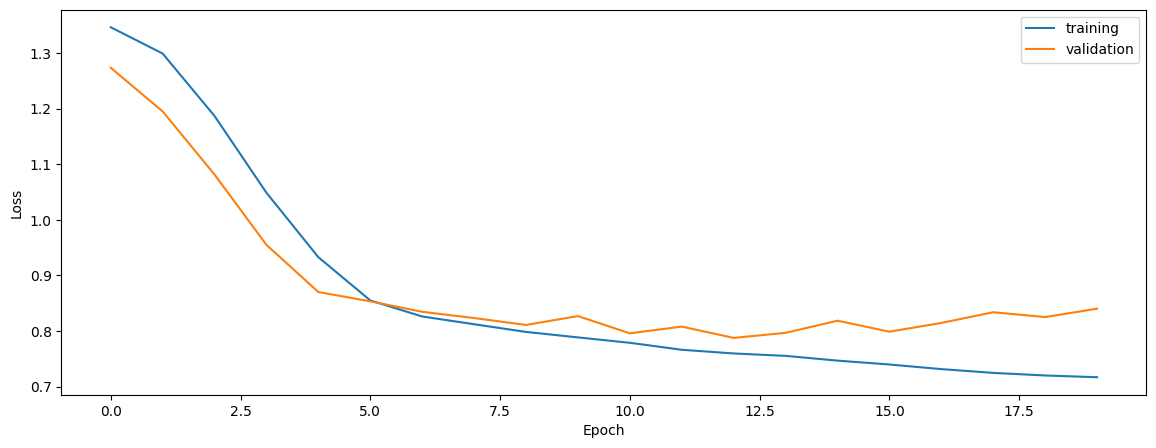

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


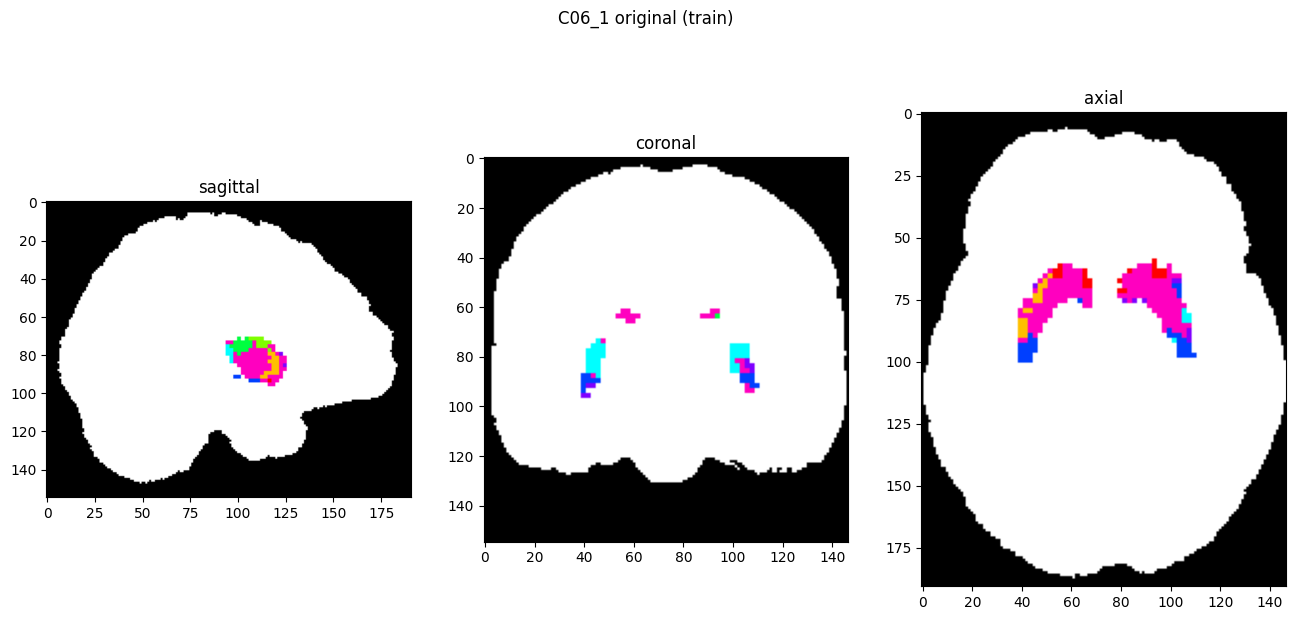

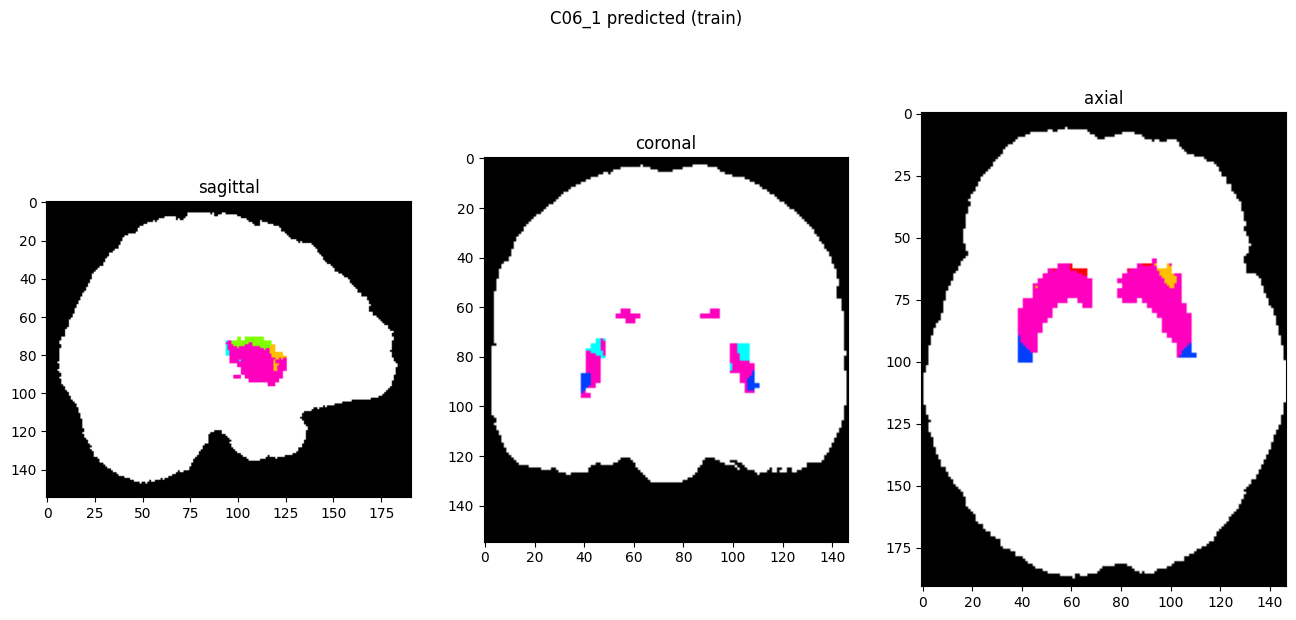

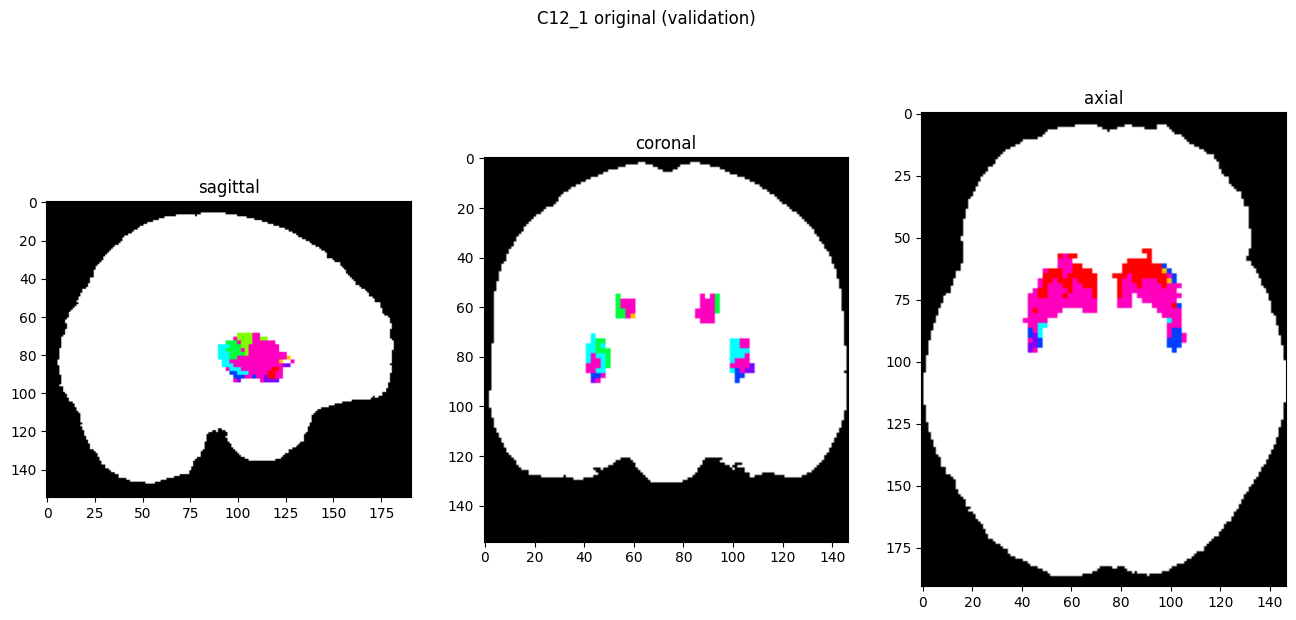

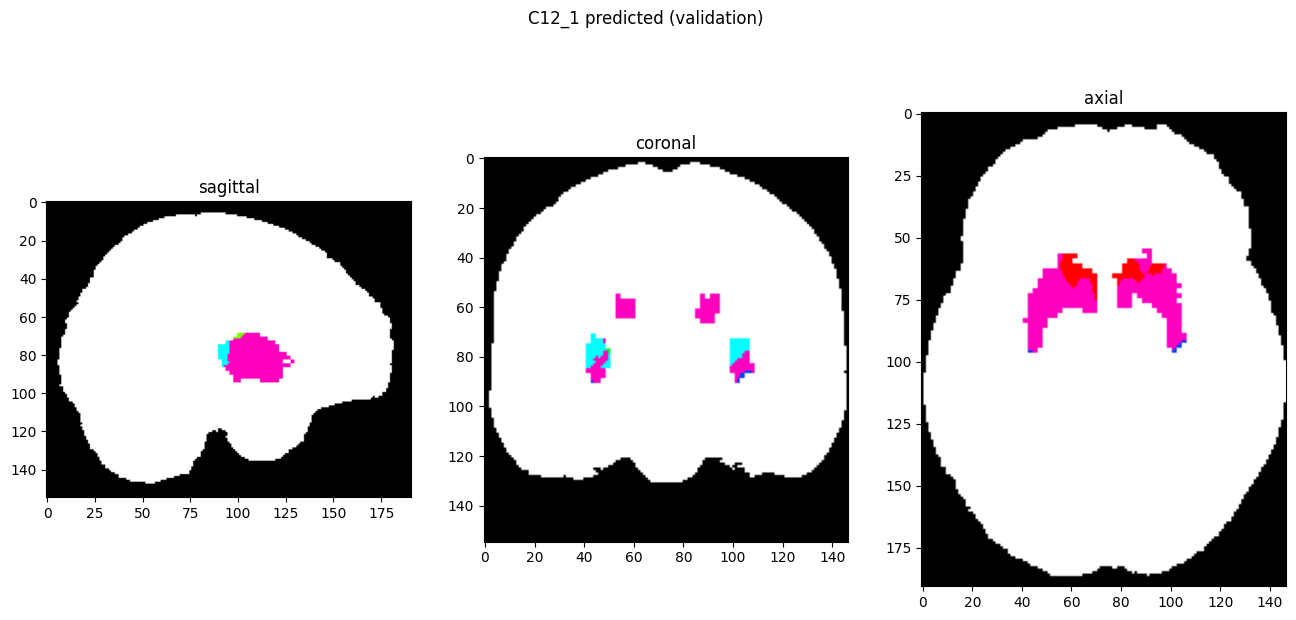

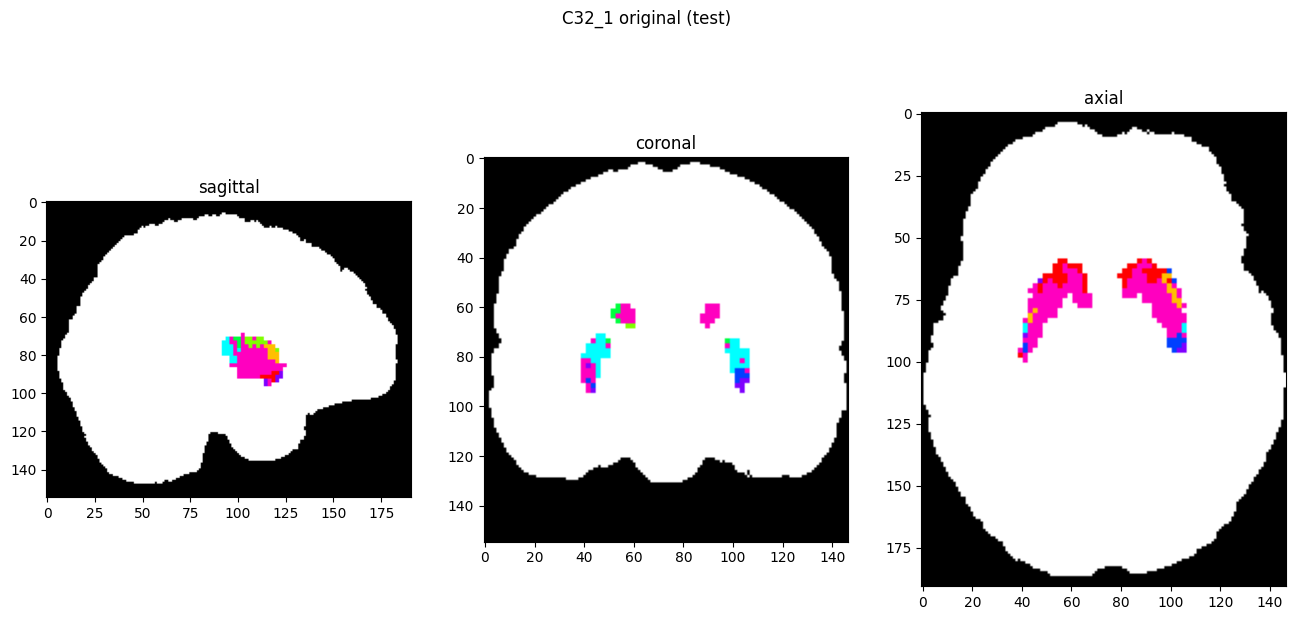

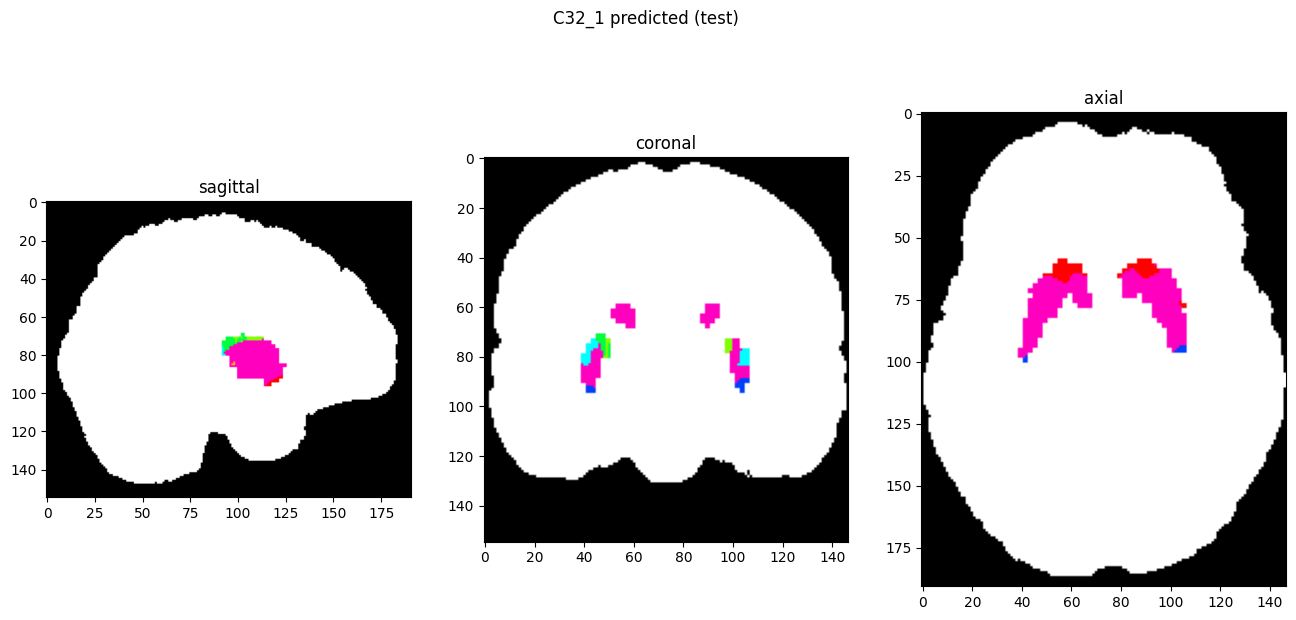

In [10]:
showResults(model, gen, threshold=0)